## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Data Cleansing

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_value = pd.concat([total, percent], axis=1).rename(columns={0:'count', 1:'percentage'})
missing_value

,count,percentage
CustomerID,135080,0.249267
Description,1454,0.002683
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
StockCode,0,0.000000
InvoiceNo,0,0.000000


* `CustomerID` dan `Description` merupakan dua kolom yang memiliki _missing value_
* Untuk dua kolom tersebut bisa kita _drop missing value by row_

In [6]:
df.dropna(axis=0, inplace=True)

* Pada info sebelumnya, kolom `InvoiceDate` dan `CustomerID` harus kita ubah tipe datanya
* Adapun tipe data dari masing-masing kolom tersebut kita ubah menjadi `datetime64[ns]` dan `str`

In [7]:
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')
df['CustomerID'] = df['CustomerID'].astype('int64')
df['CustomerID'] = df['CustomerID'].astype('str')

## Exploratory Data Analysis

### Cohort Analysis

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [9]:
len(df.loc[df['Quantity']<0])

8905

* Kolom `Quantity` memiliki sejumlah item yang bernilai negatif
* Kita asumsikan masalah tersebut sebagai item yang dikembalikan/_return_
* Terdapat ~9k pembelian item yang bernilai negatif
* Baris dengan quantity item bernilai negatif kita hapus dari dataset
* Selain itu, pada kolom `UnitPrice` harga minimum dari sebuah item adalah 0, kok bisa?

* Kita coba hitung jumlah order atau pesanan dari masing-masing customer

In [10]:
mult_order = df.pivot_table(index='CustomerID', values='InvoiceNo', aggfunc=pd.Series.nunique).reset_index()
mult_order = mult_order.rename(columns={'InvoiceNo':'Total Order'})
mult_order = mult_order.sort_values(by='Total Order', ascending=False).reset_index(drop=True)
mult_order.head()

,CustomerID,Total Order
0,14911,248
1,12748,224
2,17841,169
3,14606,128
4,13089,118


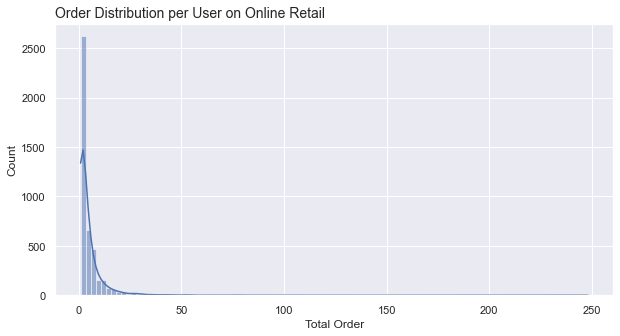

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data=mult_order, x='Total Order', bins=100, kde=True, ax=ax)
plt.title('Order Distribution per User on Online Retail', loc='left', fontsize=14)

plt.show()

* Distribusi di atas memperlihatkan data yang miring ke kanan
* Selain itu juga bisa kita simpulkan bahwa terdapat sejumlah user dengan order yang lebih dari sekali
* Hal ini bisa menjadi indikasi bahwa setidaknya terdapat beberapa retention

In [12]:
condition = mult_order['Total Order'] > 1
more_one = len(mult_order.loc[condition, 'CustomerID'])/mult_order.loc[:,'CustomerID'].nunique()
print(f'{round(100*more_one,2)}% customer dengan jumlah order lebih dari sekali')

69.97% customer dengan jumlah order lebih dari sekali


* Asumsikan bahwa data tersebut merupakan data dari awal toko tersebut dibuka
* Berdasarkan asumsi tersebut, maka min value dari `InvoiceDate` tiap customer merupakan tanggal pertama mereka bertransaksi di toko tersebut
* Sehingga kita akan coba untuk melakukan cohort analysis dari pembelian tiap user pada periode tertentu

In [13]:
new_df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates(ignore_index=True)
new_df.head()

,CustomerID,InvoiceNo,InvoiceDate
0,17850,536365,2010-12-01 08:26:00
1,17850,536366,2010-12-01 08:28:00
2,13047,536367,2010-12-01 08:34:00
3,13047,536368,2010-12-01 08:34:00
4,13047,536369,2010-12-01 08:35:00


In [14]:
new_df['order_month'] = new_df['InvoiceDate'].dt.to_period('M')

# New column with min InvoiceDate per CustomerID
new_df['cohort'] = new_df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [15]:
from operator import attrgetter

# Aggregate by cohort and order_month to find out unique number of CustomerID
new_df_cohort = new_df.pivot_table(index=['cohort', 'order_month'],
                                   values='CustomerID', aggfunc=pd.Series.nunique).reset_index()
new_df_cohort.rename(columns={'CustomerID':'n_customer'}, inplace=True)

# Find the diff between two period of time (order_month and cohort)
new_df_cohort['period_number'] = (new_df_cohort['order_month'] - new_df_cohort['cohort']).apply(attrgetter('n'))
new_df_cohort.head()

,cohort,order_month,n_customer,period_number
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4


In [16]:
pivot_cohort = new_df_cohort.pivot_table(index='cohort', columns='period_number',
                                         values='n_customer')

cohort_size = pivot_cohort.iloc[:,0]
new_pivot_cohort = pivot_cohort.divide(cohort_size, axis=0)
new_pivot_cohort

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


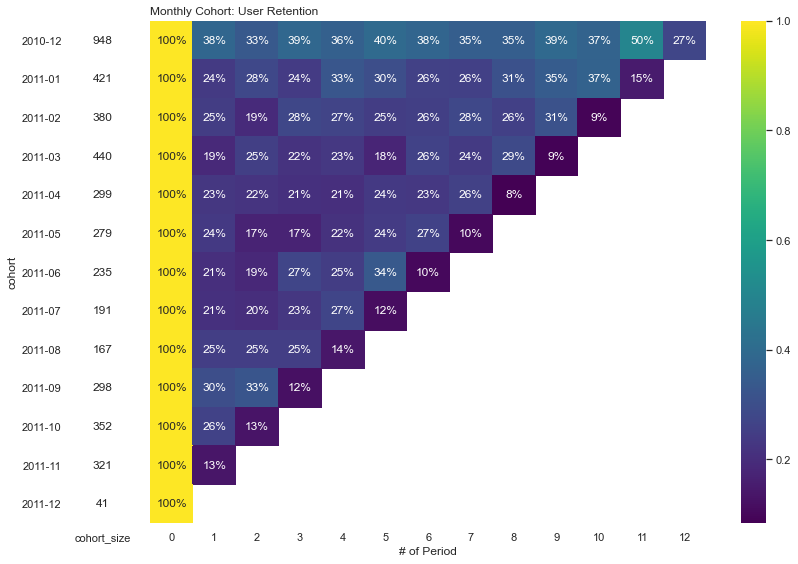

In [17]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(new_pivot_cohort, annot=True, fmt='.0%', cmap='viridis', ax=ax[1])
    ax[1].set_title('Monthly Cohort: User Retention', loc='left')
    ax[1].set(xlabel='# of Period', ylabel='')
    
    # cohort size
    cohort_size = pd.DataFrame(cohort_size).rename(columns={0:'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size, annot=True, fmt='g', cbar=False, cmap=white_cmap, ax=ax[0])
    
    fig.tight_layout()

* Rata-rata user retention hanya berada pada angka sekitar 20% hingga 30%
* User retention yang tergabung dalam bulan pertama merupakan yang paling tinggi dibandingkan dengan bulan kedua dan seterusnya
* Selain itu, user retention pada bulan pertama setelah hampir setahun mengalami peningkatan hingga 50%

### Prediction on Sales

In [18]:
df['InvoiceDate'].describe()

count                  406829
unique                  20460
top       2011-11-14 15:27:00
freq                      543
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object